In [1]:
!pip install arabic-reshaper python-bidi

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import requests
from PIL import Image
from io import BytesIO
import arabic_reshaper
from bidi.algorithm import get_display
import textwrap
from math import ceil
import time

In [3]:
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

# Load Flickr Dataset:

In [4]:
import glob
images_dirc = glob.glob('/kaggle/input/flickr8k/Images/*.jpg')
image_dict = {os.path.basename(path): path for path in images_dirc}

In [5]:
caption_df = pd.read_csv('/kaggle/input/arabic-captions-for-flickr8k-dataset/Flickr8k_arabic_text.txt', sep='\t', header=None, names=['image', 'caption'])
caption_df['image'] = caption_df['image'].apply(lambda x: x.split('#')[0])
caption_df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1001773457_577c3a7d70.jpg   
4  1001773457_577c3a7d70.jpg   

                                             caption  
0                     طفلة صغيرة تتسلق إلى مسرح خشبي  
1                  طفلة صغيرة تتسلق الدرج إلى منزلها  
2   فتاة صغيرة في ثوب وردي تذهب إلى المقصورة الخشبية  
3  كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما ا...  
4  كلب أسود وكلب أبيض ببقع بنية يحدقان في بعضهما ...

In [6]:
caption_df.shape

(24274, 2)

# Remove Duplicated Images:

In [7]:
print("Before:", len(caption_df))
print("Unique images:", caption_df['image'].nunique())

Before: 24274
Unique images: 8092


In [8]:
# Remove duplicates first
caption_df = caption_df.drop_duplicates(subset=['image']).reset_index(drop=True)
caption_df.shape

(8092, 2)

In [9]:
sample_df = caption_df.sample(8, random_state=42)

# Step 3: Load the corresponding images
images = [plt.imread(image_dict[img]) for img in sample_df['image']]
captions = sample_df['caption'].tolist()

# Show some images:

In [10]:
def show(images, captions, max_chars=40):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))

    if n == 1:
        axes = [axes]

    for ax, img, caption in zip(axes, images, captions):
        ax.imshow(img)
        ax.axis("off")
        
        # Reshape and fix Arabic text
        reshaped_text = arabic_reshaper.reshape(caption)
        bidi_text = get_display(reshaped_text)
        
        # Wrap long text into multiple lines
        wrapped_lines = textwrap.wrap(bidi_text, max_chars)
        
        # Reverse the order of lines so they show correctly
        wrapped = "\n".join(reversed(wrapped_lines))
        
        # Place caption under the image
        ax.set_title(wrapped, fontsize=12, fontname="Arial", pad=20)

    plt.tight_layout()
    plt.show()


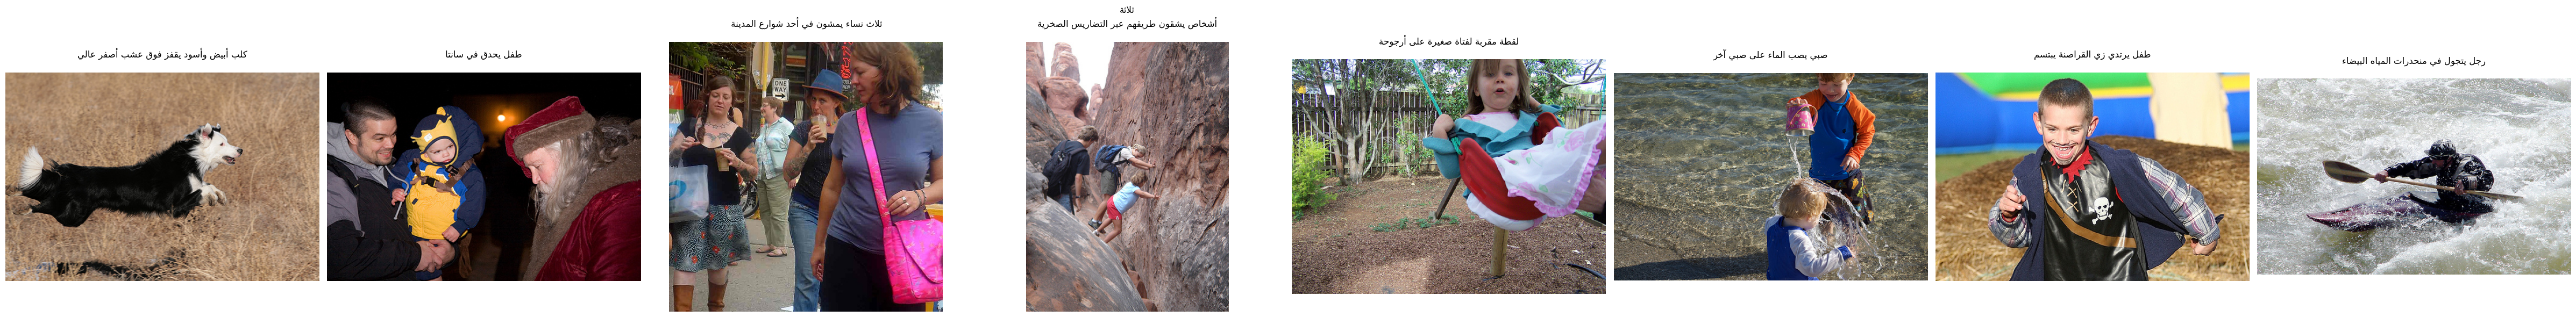

In [11]:
show(images, captions)

# Load Gemma Model:

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
apikey = user_secrets.get_secret("google_ai")

In [ ]:
from google import genai
from google.genai import types


client = genai.Client(api_key = apikey)

def gemma_caption(image_path, prompt="صف الصورة في جملة قصيرة"):
    with open(image_path, 'rb') as f:
        img_bytes = f.read()
    resp = client.models.generate_content(
        model="gemma-3-27b-it",
        contents=[
            types.Part.from_bytes(data=img_bytes, mime_type='image/jpeg'),
            prompt
        ]
    )
    return resp.text

# Split the generation of captions into days:

In [14]:
total_images = len(caption_df)
images_per_day = 250  # customize this
num_days = ceil(total_images / images_per_day)

# --- Set your current day ---
current_day = 5  # change this each day: 1, 2, 3, ...
start_idx = (current_day - 1) * images_per_day
end_idx = start_idx + images_per_day
sample = caption_df.iloc[start_idx:end_idx]
print(f'number of days: {num_days} \n started from : {start_idx}, to :{end_idx}\n total images :{total_images}')

number of days: 33 
 started from : 1000, to :1250
 total images :8092


# Generate captions:

In [15]:
captions_gen = []
failed = []

In [ ]:
for img_name in sample['image']:
    img_path = image_dict[img_name]
    try:
        cap = gemma_caption(img_path)
        captions_gen.append((img_name, cap))
        print('caption generated ')
    except Exception as e:
        print(f"Error on {img_name}: {e}")
        failed.append(img_name)
    time.sleep(0.5)  # respect rate limits


caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption generated 
caption gene

# Save the generated captions as dataset:

In [ ]:
# --- Save today’s results ---
output_path = f"/Data/Gemma_captions/Gemma_captions_day{current_day}.csv"
pd.DataFrame(captions_gen, columns=["image", "caption"]).to_csv(output_path, index=False)

print(f"Saved: {output_path}")
print(f"Failed: {len(failed)} images")

Saved: /kaggle/working/Gemma_captions_day5.csv
Failed: 0 images


# Show an Example:

In [18]:
captions_gen[5]

('2100909581_b7dde5b704.jpg',
 'بالتأكيد، إليك وصف للصورة في جملة قصيرة:\n\nكلب لابرادور أبيض اللون يقفز في الهواء بفرح في يوم تساقط فيه الثلج.')